## Построение социальных графов. Меры центральности

**Задание 1 (10 баллов)** 

Прочитайте данные из ```emails.csv```. В колонке ```message``` содержится информация о письме. Вам нужно сформировать несколько таблиц по данным для комфортной работы. 

Во-первых, у Вас имеется информация от том от когдо было отправленно письмо и кому:

* ```From``` - email отправителя
* ```X-From``` - имя отправитела 
* ```To``` - email получателя 
* ```X-To``` - имя получателя

Каждому индивидууму нужно присвоить свой уникальный ```id``` и сформировать таблицу, где по нему можно получить ```email``` и имя.

Также Вам нужно сформировать таблицу, в которой по каждому письму будет содержаться: 

* Дата
* ```id``` отправителя
* ```id``` получателей (обратитие внимание на то, что одно письмо может получать несколько человек)
* Текст

In [1]:
import sys
sys.path.append('C:\Program Files\Anaconda3\Lib\site-packages')

In [2]:
import pandas as pd
import re
from tqdm import tqdm

In [3]:
emails = pd.read_csv('D:/baklazhan/Compling/programmimng_solutions/python_nlp-master/emails.csv')

In [4]:
emails_sample = emails.sample(n = 10000)

In [5]:
emails_sample = emails_sample.reset_index(drop = True)

In [12]:
def parse_emails(df):
    contacts_dict = {}
    parsed_emails = []
    
    for index, row in tqdm(df.iterrows()):
        email_dict = {}
        meta = ''
        text = ''
        mail_from = ''
        name_from = ''
        mail_to_list = []
        name_to_list = []
        
        message_split = row['message'].split('\n\n')
        meta = message_split[0]
        text = ('\n\n'.join(message_split[1:])).strip()
        email_dict.setdefault('text',text)
        
        meta_list = meta.replace('\n\t','').replace('\n ',' ').split('\n')
        for attr in meta_list:
            attr = attr.split(': ')
            if (attr[0] == 'Date'):
                date = attr[1]
                email_dict.setdefault('date',date)
            if (attr[0] == 'From'):
                mail_from = attr[1]
            if (attr[0] == 'To'):
                mail_to_list = attr[1].split(', ')
            if (attr[0] == 'X-From'):
                name_from = attr[1]
            if (attr[0] == 'X-To'):

                names_to = re.sub('([-\w\.() ]+),?([-\w\.() ]+) <[-\w\./=@]+>', '\\1\\2', attr[1])
                names_to = (re.sub('("[-\w\.() ]+),?([-\w\.() ]+")' , '\\1\\2', names_to)).replace('"','')
                name_to_list = names_to.split(', ')

        #print(mail_from, name_from)
        name_from = re.sub(r'<.*?>', '', name_from.replace('@ ENRON', '').replace('@ENRON', ''))
        email_dict.setdefault('mail_from', mail_from)
        email_dict.setdefault('name_from', name_from)
        contacts_dict.setdefault(mail_from, name_from.strip())

        
        if len(mail_to_list) > len(name_to_list):
            dif = len(mail_to_list) - len(name_to_list)
            for i in range(dif):
                name_to_list.append('')
        
        if (mail_to_list and name_to_list):
            email_dict.setdefault('mail_to', mail_to_list)
            email_dict.setdefault('name_to', name_to_list)
            for mail_to, name_to in zip(mail_to_list, name_to_list):
                name_to = re.sub(r'<.*?>', '', name_to.replace('@ ENRON', '').replace('(E-mail)', '').replace('@ENRON',''))
                name_to = re.sub(r'SF40#.+#', '', name_to)
                if name_to:
                    contacts_dict.setdefault(mail_to, name_to.strip())
                else:
                    contacts_dict.setdefault(mail_to, mail_to)
                #print(index, mail_to, name_to)   
        parsed_emails.append(email_dict)       
    return contacts_dict, parsed_emails


In [13]:
contacts_dict, parsed_emails_list = parse_emails(emails_sample)

10000it [00:08, 1169.49it/s]


In [17]:
emails_sample['parsed_emails'] = parsed_emails_list

In [18]:
emails_sample.head()

,file,message,parsed_emails
0,taylor-m/archive/2001_07/55.,Message-ID: <3143387.1075861966547.JavaMail.ev...,{'text': 'Mark -- Attached is a list of ISDA's...
1,germany-c/inbox/213.,Message-ID: <19615791.1075852115296.JavaMail.e...,{'text': 'COLUMBIA GAS TRANSMISSION CORPORATIO...
2,bass-e/sent/345.,Message-ID: <23812407.1075854693699.JavaMail.e...,"{'text': 'Well, we are supposed to have a game..."
3,buy-r/sent_items/86.,Message-ID: <4612093.1075862187890.JavaMail.ev...,{'text': 'Hi Jule- thought about your comment ...
4,lenhart-m/notes_inbox/7.,Message-ID: <17359264.1075858137571.JavaMail.e...,"{'text': 'Come on Matt, simply because Max is ..."


In [19]:
len(contacts_dict)

13947

In [20]:
contacts = pd.DataFrame(data = list(zip(contacts_dict.keys(), contacts_dict.values())), 
                       columns = ['email', 'name'])

In [21]:
contacts = contacts.reset_index()
contacts.columns = ['id', 'email','name']
contacts.head()

,id,email,name
0,0,douglas.allen@enron.com,Douglas Allen
1,1,denver.plachy@enron.com,Plachy Denver
2,2,marie.westin@enron.com,Weinreich Colette
3,3,darin.schmidt@enron.com,Darin Schmidt
4,4,salil.pradhan@enron.com,Pack Jr. Scott


In [22]:
contacts.shape

(13947, 3)

In [23]:
def make_emails_df(raw_emails_df, contacts_df):
    dates = []
    texts = []
    id_from = []
    id_to = []
    
    for index, row in tqdm(raw_emails_df.iterrows()):
        parsed_message = row['parsed_emails']
        dates.append(parsed_message['date'])
        texts.append(parsed_message['text'])
        
        email_from = parsed_message['mail_from']
        id_from.append(int(contacts_df[contacts_df.email == email_from].id))
        
        try:
            emails_to_list = parsed_message['mail_to']
        except KeyError:
            emails_to_list = []
            
        id_to_list = []
        if emails_to_list:
            for email_to in emails_to_list:
                id_to_list.append(str(int(contacts_df[contacts_df.email == email_to].id)))
            id_to.append(','.join(id_to_list))
        else:
            id_to.append('')  
            
    emails_df = pd.DataFrame({'date':dates, 'id_from':id_from, 'id_to':id_to, 'text':texts})
    return emails_df

In [32]:
for index, row in emails_sample.iterrows():
    message_split = row['message'].split('\n\n')
    meta = message_split[0]
    text = '\n\n'.join(message_split[1:])
    #texts.append(text)
    #meta_list = meta.replace('\n\t','').replace('\n ',' ').split('\n')
    #for attr in meta_list:
     #   attr = attr.split(': ')
      #  if (attr[0] == 'To'):
       #     if ('navigator@nisource.com' in attr[1]):
        #        print(index, meta)
    if 'Well, we are supposed to have a game tonight' in text:
        print(index, meta)

2 Message-ID: <23812407.1075854693699.JavaMail.evans@thyme>
Date: Wed, 13 Sep 2000 01:22:00 -0700 (PDT)
From: eric.bass@enron.com
To: brian.hoskins@enron.com, matthew.lenhart@enron.com, 
	timothy.blanchard@enron.com, bryan.hull@enron.com, 
	jeffrey.gossett@enron.com, o'neal.winfree@enron.com, 
	david.baumbach@enron.com, kenneth.shulklapper@enron.com, 
	nick.hiemstra@enron.com
Subject: GAME TONIGHT @ 7:30
Cc: luis.mena@enron.com, amir.ahanchian@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: luis.mena@enron.com, amir.ahanchian@enron.com
X-From: Eric Bass
X-To: Brian Hoskins, Matthew Lenhart, Timothy Blanchard, Bryan Hull, Jeffrey C Gossett, O'Neal D Winfree, David Baumbach, Kenneth Shulklapper, Nick Hiemstra
X-cc: Luis Mena, Amir Ahanchian
X-bcc: 
X-Folder: \Eric_Bass_Dec2000\Notes Folders\Sent
X-Origin: Bass-E
X-FileName: ebass.nsf


In [27]:
emails_df = make_emails_df(emails_sample, contacts)


10000it [07:34, 22.02it/s]


In [28]:
emails_df.head(20)

,date,id_from,id_to,text
0,"Wed, 11 Jul 2001 13:51:20 -0700 (PDT)",4415,5383,Mark -- Attached is a list of ISDA's NA Energy...
1,"Wed, 17 Oct 2001 07:21:21 -0700 (PDT)",7815,7815,COLUMBIA GAS TRANSMISSION CORPORATION\n ...
2,"Wed, 13 Sep 2000 01:22:00 -0700 (PDT)",7853,"6318,2379,11187,12022,6719,11017,3026,8322,2524","Well, we are supposed to have a game tonight a..."
3,"Wed, 31 Oct 2001 07:11:51 -0800 (PST)",757,7565,Hi Jule- thought about your comment about Fide...
4,"Wed, 21 Mar 2001 10:16:00 -0800 (PST)",1572,"2379,5537","Come on Matt, simply because Max is Jewish doe..."
5,"Thu, 29 Mar 2001 00:06:00 -0800 (PST)",10101,7443,----- Forwarded by Steven J Kean/NA/Enron on 0...
6,"Wed, 22 Nov 2000 04:46:00 -0800 (PST)",757,1961,sounds like an opportunity for our illustrious...
7,"Mon, 17 Dec 2001 15:42:46 -0800 (PST)",1956,8097,"RIGZONE DAILY NEWS -- TUESDAY, DECEMBER 18, 20..."
8,"Mon, 12 Nov 2001 09:17:44 -0800 (PST)",11451,1281,We are totally LBs. no DEs. We had a bad defen...
9,"Thu, 7 Jun 2001 10:41:00 -0700 (PDT)",9719,969,You have been sent this message from lisa.yoho...


In [36]:
emails_df[emails_df.id_to == ''].shape

(409, 4)

In [37]:
emails_df = emails_df[emails_df.id_to != '']

In [38]:
emails_df = emails_df.reset_index(drop=True)

In [39]:
emails_df.shape

(9591, 4)

In [40]:
contacts.shape

(13947, 3)

**Задание 2 (15 баллов)** 

Сформируйте матрицу $A = (a_{ij})_{i,j = 1}^N$, где $a_{ij}$ - количество писем, которое индивид $i$ отправил индивиду $j$, $N$ - количество индивидуумов

Далее из матрицы $A$ получим симметричную матрицу, которая будет показывать нам частоту коммуникаций между каждой парой индивидов: $A+A^T$. Постройте по данной матрице не направленный граф, где узлы должны называться по именам, которые вы извлекли из ```X-From``` и ```X-To```

**Замечание.** Так как граф слишком большой, то вы можете оставить только наиболее активных участников.

In [41]:
import numpy as np

In [42]:
def make_communication_matrix(df, contacts):
    N = contacts.shape[0]
    A = np.zeros((N,N))
    
    for index, row in df.iterrows():
        from_i = row['id_from']
        for to_j in row['id_to'].split(','):
            A[from_i][int(to_j)] += 1
    return A + np.transpose(A)
        

In [43]:
%%time
communication_matrix = make_communication_matrix(emails_df, contacts)

Wall time: 21.1 s


In [44]:
communication_matrix.shape

(13947, 13947)

In [45]:
max_com = communication_matrix.max()
max_com

370.0

In [48]:
np.argmax(communication_matrix)

115308116

In [49]:
communication_matrix.mean()

0.00058727482749495964

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

In [51]:
import networkx as nx

In [52]:
commun_measures = []
i, j = np.where(communication_matrix > 20)
for i_num, j_num in zip(i,j):
 #   if i_num > j_num:
    commun_measures.append(communication_matrix[i_num][j_num])
print(len(i))

74


In [57]:
commun_measures = commun_measures/max_com

In [58]:
communications = pd.DataFrame({'source':i, 'target':j, 'weight': commun_measures})

In [60]:
labels = dict(zip(contacts.id, contacts.name))

In [61]:
communications['source_name'] = [labels[source_id] for source_id in communications.source]
communications['target_name'] = [labels[target_id] for target_id in communications.target]

In [62]:
communications.head()

,source,target,weight,source_name,target_name
0,363,6859,0.000329,All Enron Worldwide,Enron Announcements
1,630,7033,0.000212,Janel Guerrero,Jeff Dasovich
2,969,2711,0.000175,richard.shapiro@enron.com,Susan J Mara
3,969,7033,0.000482,richard.shapiro@enron.com,Jeff Dasovich
4,969,10101,0.000153,richard.shapiro@enron.com,Steven J Kean


C:\Program Files\Anaconda3\envs\mllecture\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Program Files\Anaconda3\envs\mllecture\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Program Files\Anaconda3\envs\mllecture\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Program Files\Anaconda3\envs\mllecture\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed

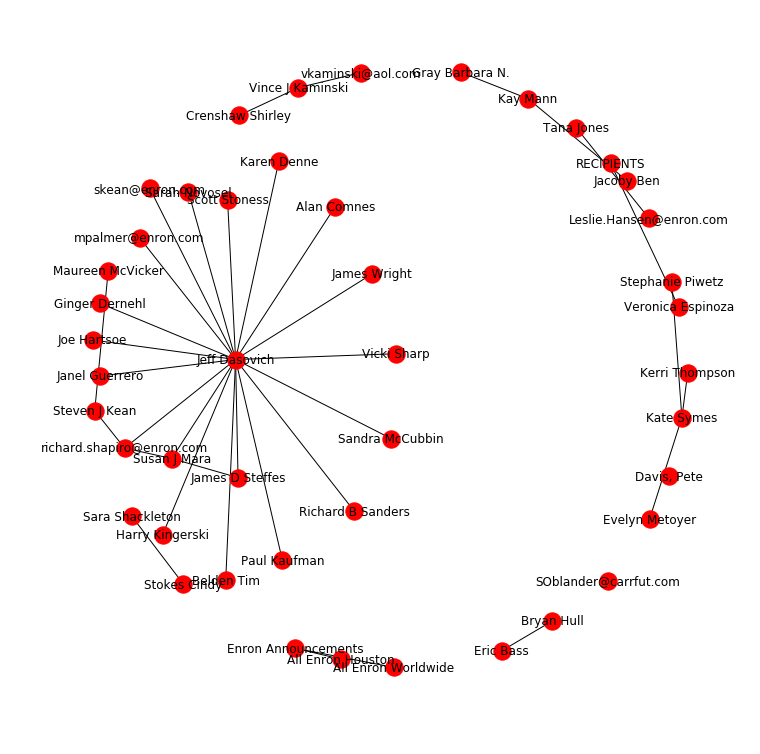

In [70]:
G = nx.from_pandas_dataframe(communications, 'source_name', 'target_name')

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels = True)
plt.show()

**Задание 3 (25 баллов)**

Оцените важность отдельных узлов, используя следующие меры:

* Degree centrality
* Closeness centrality
* Betweenness centrality
* Eigenvector centrality

Подробнее читайте в статье: УЗЛЫ В СОЦИАЛЬНЫХ СЕТЯХ: МЕРЫ ЦЕНТРАЛЬНОСТИ И РОЛЬ В СЕТЕВЫХ ПРОЦЕССАХ

Для каждой меры центральности выведите топ пользователей

In [71]:
sorted(nx.degree_centrality(G).items(), key = lambda x: x[1], reverse = True)[:20]

[('Jeff Dasovich', 0.4318181818181818),
 ('richard.shapiro@enron.com', 0.06818181818181818),
 ('Kate Symes', 0.06818181818181818),
 ('Susan J Mara', 0.06818181818181818),
 ('Kay Mann', 0.045454545454545456),
 ('Davis, Pete', 0.045454545454545456),
 ('Steven J Kean', 0.045454545454545456),
 ('James D Steffes', 0.045454545454545456),
 ('SOblander@carrfut.com', 0.045454545454545456),
 ('Vince J Kaminski', 0.045454545454545456),
 ('Enron Announcements', 0.045454545454545456),
 ('Gray Barbara N.', 0.022727272727272728),
 ('Ginger Dernehl', 0.022727272727272728),
 ('Stephanie Piwetz', 0.022727272727272728),
 ('vkaminski@aol.com', 0.022727272727272728),
 ('Leslie.Hansen@enron.com', 0.022727272727272728),
 ('skean@enron.com', 0.022727272727272728),
 ('Eric Bass', 0.022727272727272728),
 ('Alan Comnes', 0.022727272727272728),
 ('Richard B Sanders', 0.022727272727272728)]

In [72]:
sorted(nx.closeness_centrality(G).items(), key = lambda x: x[1], reverse = True)[:20]

[('Jeff Dasovich', 0.41761363636363635),
 ('richard.shapiro@enron.com', 0.256993006993007),
 ('Susan J Mara', 0.25056818181818186),
 ('James D Steffes', 0.23308668076109937),
 ('Ginger Dernehl', 0.22778925619834714),
 ('skean@enron.com', 0.22778925619834714),
 ('Alan Comnes', 0.22778925619834714),
 ('Richard B Sanders', 0.22778925619834714),
 ('Sarah Novosel', 0.22778925619834714),
 ('Vicki Sharp', 0.22778925619834714),
 ('mpalmer@enron.com', 0.22778925619834714),
 ('Janel Guerrero', 0.22778925619834714),
 ('James Wright', 0.22778925619834714),
 ('Joe Hartsoe', 0.22778925619834714),
 ('Belden Tim', 0.22778925619834714),
 ('Scott Stoness', 0.22778925619834714),
 ('Harry Kingerski', 0.22778925619834714),
 ('Paul Kaufman', 0.22778925619834714),
 ('Karen Denne', 0.22778925619834714),
 ('Sandra McCubbin', 0.22778925619834714)]

In [66]:
sorted(nx.betweenness_centrality(G).items(), key = lambda x: x[1], reverse = True)[:20]

[('Jeff Dasovich', 0.21300211416490486),
 ('richard.shapiro@enron.com', 0.04016913319238901),
 ('Steven J Kean', 0.021141649048625793),
 ('Kate Symes', 0.0031712473572938693),
 ('Susan J Mara', 0.0015856236786469346),
 ('Kay Mann', 0.0010570824524312897),
 ('Vince J Kaminski', 0.0010570824524312897),
 ('Enron Announcements', 0.0010570824524312897),
 ('Gray Barbara N.', 0.0),
 ('Ginger Dernehl', 0.0),
 ('Stephanie Piwetz', 0.0),
 ('vkaminski@aol.com', 0.0),
 ('Leslie.Hansen@enron.com', 0.0),
 ('skean@enron.com', 0.0),
 ('Eric Bass', 0.0),
 ('Alan Comnes', 0.0),
 ('Richard B Sanders', 0.0),
 ('Crenshaw Shirley', 0.0),
 ('Sarah Novosel', 0.0),
 ('Davis, Pete', 0.0)]

In [74]:
sorted(nx.eigenvector_centrality(G, max_iter=1000).items(), key = lambda x: x[1], reverse = True)[:20]

[('Jeff Dasovich', 0.68862971863586),
 ('Susan J Mara', 0.24657815988457),
 ('richard.shapiro@enron.com', 0.21826521038452923),
 ('James D Steffes', 0.20701878634886403),
 ('Ginger Dernehl', 0.1524352589202673),
 ('skean@enron.com', 0.1524352589202673),
 ('Alan Comnes', 0.1524352589202673),
 ('Richard B Sanders', 0.1524352589202673),
 ('Sarah Novosel', 0.1524352589202673),
 ('Vicki Sharp', 0.1524352589202673),
 ('mpalmer@enron.com', 0.1524352589202673),
 ('Janel Guerrero', 0.1524352589202673),
 ('James Wright', 0.1524352589202673),
 ('Joe Hartsoe', 0.1524352589202673),
 ('Belden Tim', 0.1524352589202673),
 ('Scott Stoness', 0.1524352589202673),
 ('Harry Kingerski', 0.1524352589202673),
 ('Paul Kaufman', 0.1524352589202673),
 ('Karen Denne', 0.1524352589202673),
 ('Sandra McCubbin', 0.1524352589202673)]

**Бонусное задание (25 баллов)** 

Выделите темы, которые обсуждаются в письмах.

Выберите одну из мер центральности и для топа пользователей по данной мере укажите, какие темы они обсуждают чаще всего и с кем.

In [75]:
from gensim import corpora, models

C:\Program Files\Anaconda3\Lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used


In [136]:
from nltk.corpus import stopwords
eng_stop = stopwords.words('english')

In [137]:
mail_stop = ['http','com','enron','image','would', 'pm', 'www', 'sent', 'gif','e','cc', 'subject', 'date', 'thanks', 'id', 'forwarded', 'message','please','mail']
eng_stop += mail_stop

In [126]:
def preprocess(text_list):
    preprocessed_texts = []
    for text in tqdm(text_list):
        tokens = re.findall(r'[a-z]+', text.lower())
        preprocessed_texts.append(' '.join([token for token in tokens if token not in eng_stop]))
    return preprocessed_texts

In [138]:
preprocessed_mails = preprocess(emails_df.text)

100%|█████████████████████████████████████| 9591/9591 [00:16<00:00, 573.11it/s]


In [139]:
emails_df['preprocessed'] = preprocessed_mails

In [140]:
corpus = []

for text in emails_df.preprocessed:
    corpus.extend(text.split())

In [141]:
dictionary = corpora.Dictionary([corpus])

In [143]:
mails_bow = [dictionary.doc2bow(text.split()) for text in emails_df.preprocessed]

In [146]:
lda = models.ldamodel.LdaModel(corpus = mails_bow, id2word = dictionary, num_topics = 10, passes=1)

In [148]:
lda.print_topics(10)

[(0,
  '0.007*"company" + 0.007*"energy" + 0.005*"market" + 0.005*"said" + 0.005*"new" + 0.004*"gas" + 0.004*"power" + 0.004*"business" + 0.003*"trading" + 0.003*"also"'),
 (1,
  '0.007*"know" + 0.005*"time" + 0.005*"call" + 0.005*"let" + 0.005*"vince" + 0.004*"like" + 0.004*"meeting" + 0.004*"get" + 0.004*"work" + 0.004*"need"'),
 (2,
  '0.104*"omni" + 0.032*"cn" + 0.032*"forney" + 0.032*"ou" + 0.031*"dect" + 0.031*"dhou" + 0.031*"djohn" + 0.015*"updatedby" + 0.015*"omniorgtable" + 0.015*"nopurge"'),
 (3,
  '0.009*"email" + 0.009*"information" + 0.006*"click" + 0.005*"may" + 0.004*"use" + 0.004*"intended" + 0.004*"new" + 0.004*"time" + 0.004*"contact" + 0.004*"pdf"'),
 (4,
  '0.019*"omni" + 0.007*"one" + 0.007*"et" + 0.005*"way" + 0.005*"new" + 0.005*"day" + 0.004*"get" + 0.003*"gas" + 0.003*"go" + 0.003*"us"'),
 (5,
  '0.097*"ect" + 0.038*"hou" + 0.009*"corp" + 0.005*"deal" + 0.005*"enronxgate" + 0.005*"lon" + 0.005*"mark" + 0.005*"know" + 0.004*"na" + 0.004*"agreement"'),
 (6,
  '0.

С помощью LDA выделили 10 тем сообщений, некоторые из них интерпретируемы по тематическим словам: например, тема 9 связана с капиталом компании (million, firm, funding, capital), тема 7 - рынок в отрасли энергетики (power, energy, market, prices).